In [1]:
import healpy as hp
import numpy as np
import numpy.lib.recfunctions as rf
from astropy.table import Table, join
import h5py
import fitsio
import os, sys
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.optimize as optimize

import sys
sys.path.insert(0, '/global/homes/s/severett/repos/balutils/')
from balutils import stacked_catalogs as sc

import seaborn as sb
plt.style.use('seaborn')
sb.set_context("notebook", font_scale=1.5)

%load_ext autoreload
%autoreload 2

In [2]:
## Functions from E Huff
def hpRaDecToHEALPixel(ra, dec, nside=4096, nest=True):
    phi = ra * np.pi / 180.0
    theta = (90.0 - dec) * np.pi / 180.0
    hpInd = hp.ang2pix(nside, theta, phi, nest= nest)
    return hpInd

def add_maps_to_catalog(catalog, mapfile_dict, ratag='meas_ra',dectag='meas_dec', map_path=None):
    names = [*(mapfile_dict.keys())]
    nmaps = len(names)
    for iname in names:
        print (f"adding map {iname} of {nmaps}")
        fname = mapfile_dict[iname]
        hmap = fitsio.read(fname)
        hmap_big = np.zeros(hp.nside2npix(4096)) +hp.UNSEEN
        hmap_big[hmap['PIXEL']] = hmap['SIGNAL']
        hInd = hpRaDecToHEALPixel(catalog[ratag], catalog[dectag])
        catalog[iname+'_depth'] = hmap_big[hInd]
#         newcat = rf.append_fields(newcat,iname, hmap_big[hInd], usemask = False)
    return

## Load in depth maps

In [3]:
depth_maps = {}
for b in 'griz':
    fname = f'Y3A2_DEPTH_SOF_V2_2_1_{b.upper()}.fits'
#     depth_maps[b] = hp.read_map(fname, nest=True)
    depth_maps[b] = fname

## Load catalogs

In [4]:
gld = Table(fitsio.read('y3_gold_2_2_maglim_DES0000-0207.fits'))

sample = np.where( (gld['EXTENDED_CLASS_MASH_SOF'] >=2 ) &
                   (gld['FLAGS_GOLD'] < 2) &
                   (gld['FLAGS_FOREGROUND'] == 0) &
                   (gld['FLAGS_BADREGIONS'] < 2) &
                   (gld['FLAGS_FOOTPRINT'] == 1)
                 )
                  
gld = gld[sample]
print(gld)

FLAGS_GOLD EXTENDED_CLASS_MASH_SOF ...   SOF_CM_MAG_ERR_I     SOF_CM_MAG_ERR_Z  
---------- ----------------------- ... -------------------- --------------------
         0                       2 ...   -2.090619887842628  0.24132655301474853
         0                       3 ...  0.08423083160325405  0.08506587744361137
         0                       3 ... 0.003011849375333863 0.003461966876071544
         0                       3 ...  0.06589299136821583  0.10095937470801988
         0                       3 ...   0.2020768442179005   0.2296304131985814
         0                       3 ...  0.19922538258652497  0.24693918827376005
         0                       3 ...   0.2187661216424124  0.29036761005273526
         0                       3 ...  0.21431605800928172   0.4462754404855429
         0                       3 ... 0.012982101656240082 0.013827538236210015
         0                       2 ...  0.22320484110131644    0.336114331140644
       ...                  

In [5]:
run_name = 'y3-merged'
ver = '1.2'

print('det...')
det_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_detection_catalog_sof_{}_v{}.fits'.format(run_name, ver, run_name, ver)
det_cols = ['bal_id', 'meas_FLAGS_GOLD_SOF_ONLY', 'flags_footprint', 'flags_badregions', 'flags_foreground', 'match_flag_1.5_asec', 'meas_EXTENDED_CLASS_SOF']
det = Table(fitsio.read(det_file, columns=det_cols))

print('sof...')
sof_file = '/project/projectdirs/des/severett/Balrog/{}/stacked_catalogs/{}/sof/balrog_matched_catalog_sof_{}_v{}.fits'.format(run_name, ver, run_name, ver)
# sof_cols = ['bal_id', 'meas_cm_flux_deredden', 'meas_cm_flux_err', 'meas_cm_T', 'meas_cm_fracdev', 'true_bdf_flux_deredden', 'true_bdf_T', 'true_bdf_fracdev']
sof_cols = ['bal_id', 'meas_ra', 'meas_dec', 'meas_cm_mag', 'meas_tilename', 'true_bdf_mag_deredden']
sof = Table(fitsio.read(sof_file, columns=sof_cols))

print('joining...')
joined = join(det, sof, keys='bal_id')

print('cutting sample...')
tile = 'DES0000-0207'
bal = joined[joined['meas_tilename'] == tile]

sample = np.where( (bal['meas_EXTENDED_CLASS_SOF'] >= 2) &
                   (bal['meas_FLAGS_GOLD_SOF_ONLY'] < 2) &
                   (bal['flags_foreground'] == 0) &
                   (bal['flags_badregions'] < 2) &
                   (bal['flags_footprint'] == 1) &
                   (bal['match_flag_1.5_asec'] < 2)
                 )
bal = bal[sample]

det...
sof...
joining...
cutting sample...


In [6]:
## Add depths
add_maps_to_catalog(bal, depth_maps)
print(bal)

adding map g of 4
adding map r of 4
adding map i of 4
adding map z of 4
     bal_id      flags_footprint ...      i_depth            z_depth      
---------------- --------------- ... ------------------ ------------------
    100000002071             1.0 ... 22.768110275268555 22.242321014404297
    100000002074             1.0 ... 23.009544372558594  22.54656982421875
    100000002075             1.0 ... 22.872472763061523 22.428197860717773
    100000002077             1.0 ... 22.961706161499023  22.45017433166504
    100000002078             1.0 ... 22.883033752441406 22.410058975219727
    100000002079             1.0 ...   22.8983154296875 22.427955627441406
   1000000020710             1.0 ...  22.96096420288086 22.523775100708008
   1000000020711             1.0 ...  22.94965362548828 22.415908813476562
   1000000020712             1.0 ...  22.98337173461914  22.45087242126465
   1000000020718             1.0 ...  22.95603370666504  22.46918487548828
             ...            

## Fitting mag vs mag_err on data

In [7]:
# def model(x, a, b):
#     return a * np.power(x, b)

# b = 'i'
# mag = gld[f'sof_cm_mag_{b}'.upper()]
# err = gld[f'sof_cm_mag_err_{b}'.upper()]

# cuts = np.where(err > 0)
# mag, err = mag[cuts], err[cuts]

# m, b = np.polyfit(np.log(mag), np.log(err), 1)
# print(m, b)
# # popt, pcov = curve_fit(model, mag, err)
# xx = np.arange(min(mag), max(mag), (max(mag)-min(mag))/100)
# yy = b*np.exp(m*xx)
# # plt.plot(xx, model(xx, *popt), 'r-', label="({0:.3f}*x**{1:.3f})".format(*popt))
# plt.plot(xx, yy, ls='--', c='r', lw=2, label='{:.3f}x + {:.3f}'.format(m, b))
# plt.legend()

# plt.scatter(mag, err, alpha=0.5)
# plt.xlabel(f'sof_cm_mag_{b}'.upper())
# plt.ylabel(f'sof_cm_mag_err_{b}'.upper())
# plt.title(f'Fit for {tile}')

# # plt.xlim([min(mag), 26])
# # plt.yscale('log')
# # plt.ylim([1e-4, 50])
# plt.gcf().set_size_inches(8,6)

In [8]:
MAXMAG = 30
bindx = dict(zip('griz', range(4)))

for b, bi in bindx.items():
    print(b)
    mag = gld[f'sof_cm_mag_{b}'.upper()]
    err = gld[f'sof_cm_mag_err_{b}'.upper()]

    cuts = np.where( (err > 0) & (mag < MAXMAG) )
    mag, err = mag[cuts], err[cuts]

    # Define function for calculating a power law
    powerlaw = lambda x, amp, index: amp * (x**index)

    #  y = a * x^b
    #  log(y) = log(a) + b*log(x)

    logx = np.log10(mag)
    logy = np.log10(err)

    # define our (line) fitting function
    fitfunc = lambda p, x: p[0] + p[1] * x
    errfunc = lambda p, x, y: (y - fitfunc(p, x))

    pinit = [1.0, -1.0]
    out = optimize.leastsq(errfunc, pinit,
                           args=(logx, logy),
                           full_output=1)

    pfinal = out[0]
    covar = out[1]
    print(pfinal)
    print(covar)

    index = pfinal[1]
    amp = 10.0**pfinal[0]

    indexErr = np.sqrt(covar[1][1])
    ampErr = np.sqrt(covar[0][0]) * amp

g
[-26.90708822  18.86225317]
[[ 0.13607825 -0.09860566]
 [-0.09860566  0.07147137]]
r
[-23.56919191  16.50427331]
[[ 0.12683281 -0.09292102]
 [-0.09292102  0.06809577]]
i
[-22.68116799  15.96967046]
[[ 0.11969908 -0.08831793]
 [-0.08831793  0.06518357]]
z
[-22.65465271  16.08778627]
[[ 0.11055531 -0.08192779]
 [-0.08192779  0.06073305]]


g
13.0809576137608 28.8571340689278


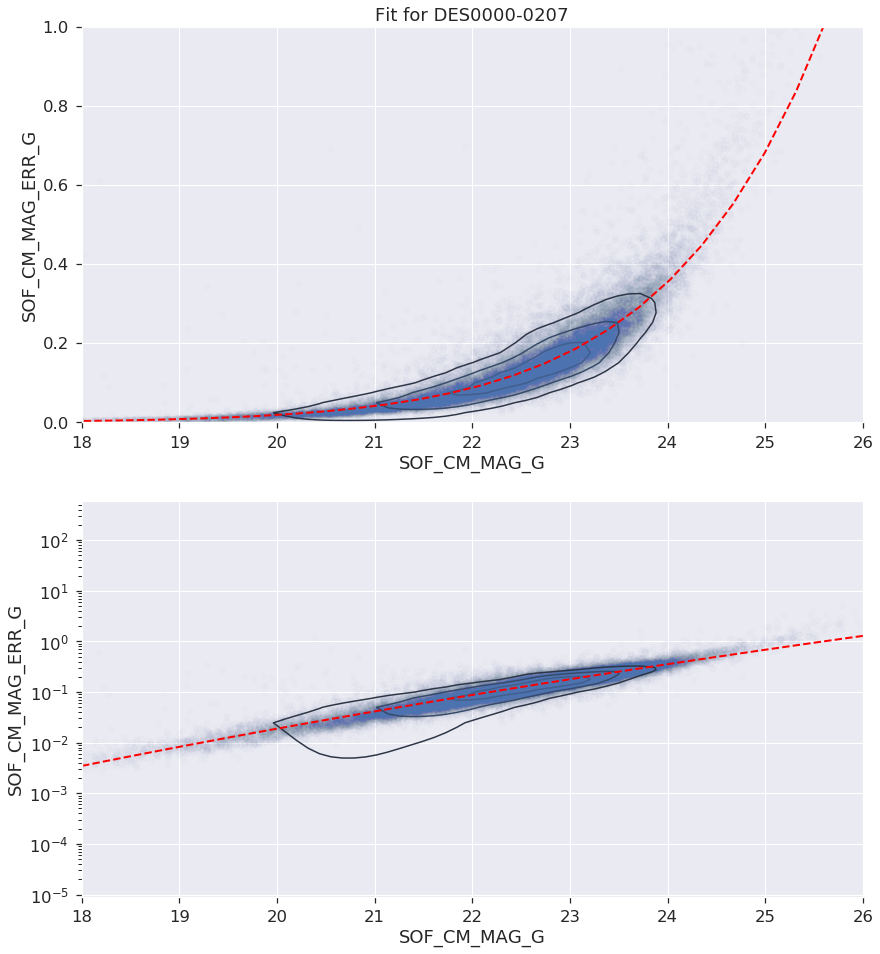

r
13.0809576137608 28.8571340689278


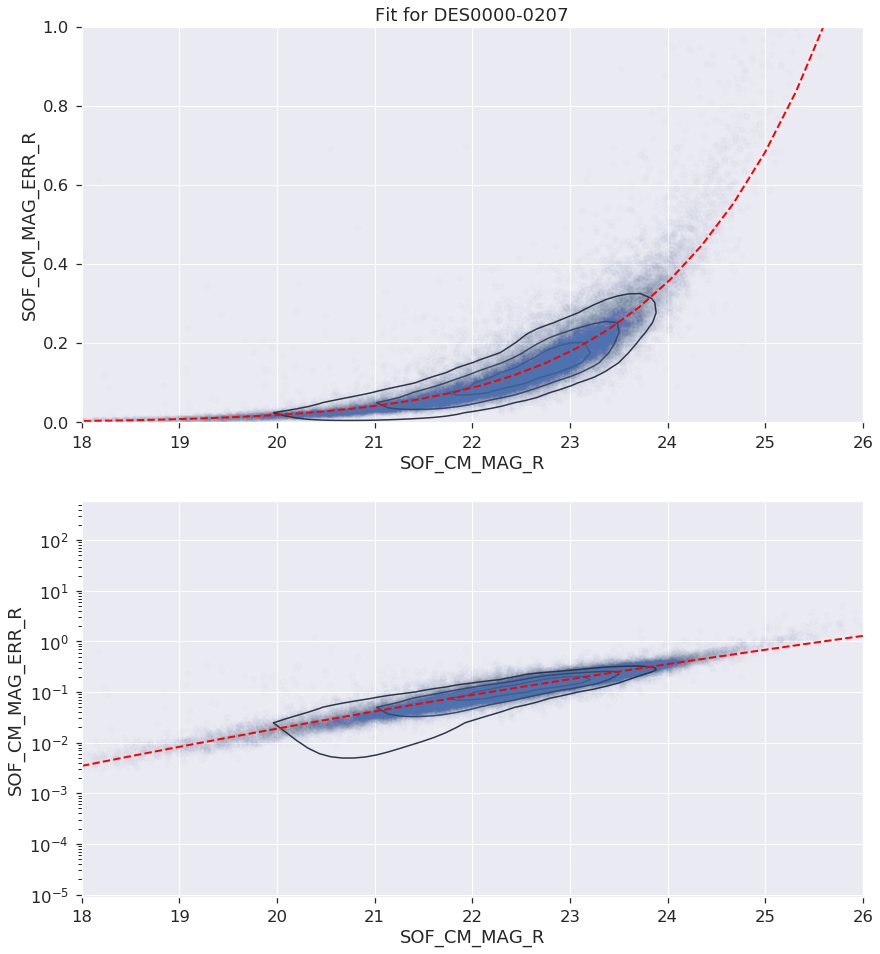

i
13.0809576137608 28.8571340689278


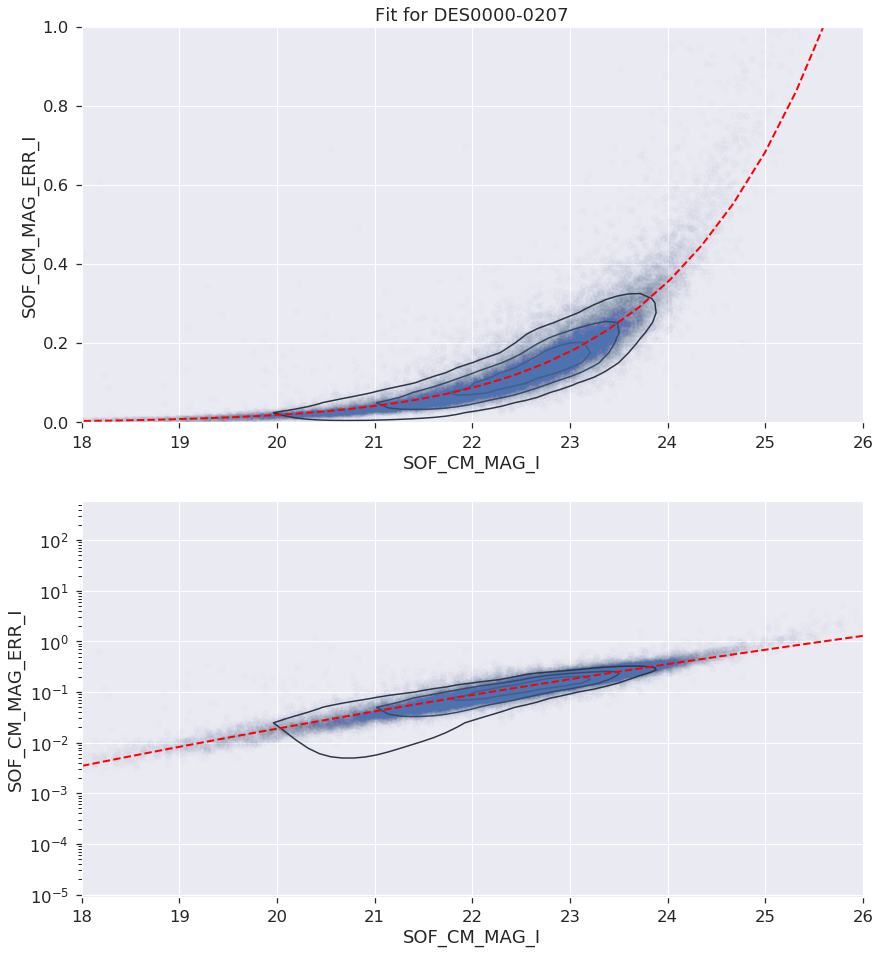

z
13.0809576137608 28.8571340689278


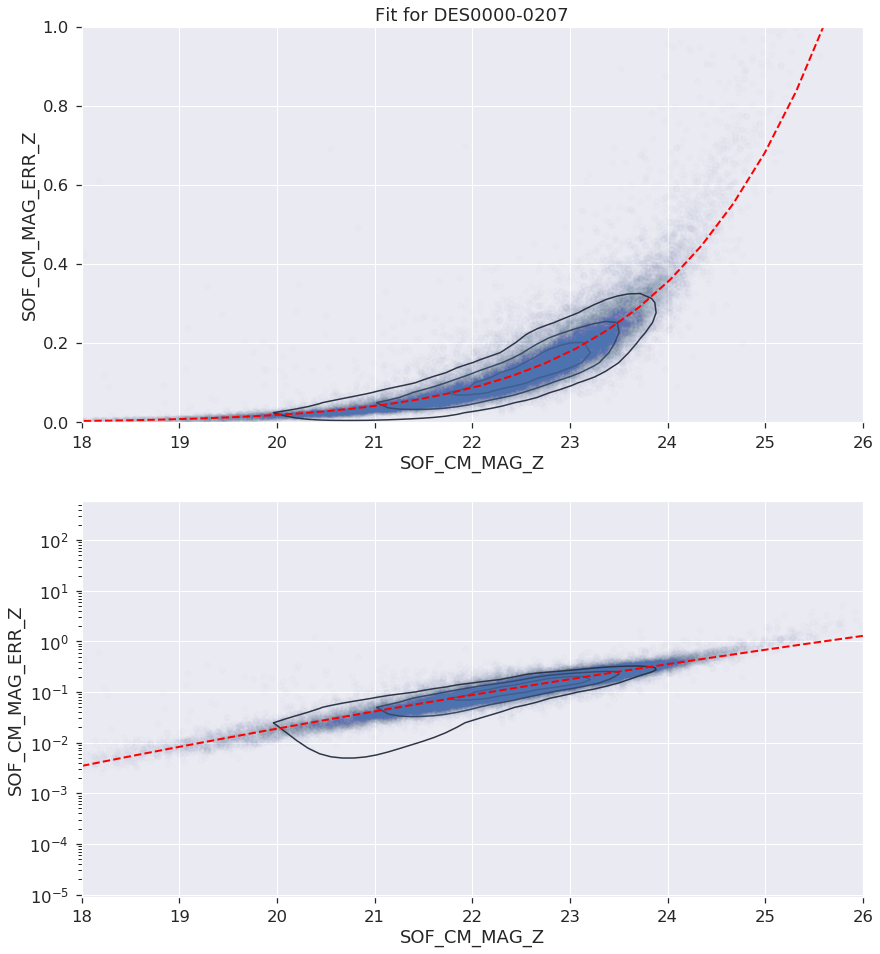

In [9]:
## Plots

xmin, xmax = 18, 26
ymin, ymax = 0, 1
n_levels = 3
N = 15
alpha = 0.025

for b in 'griz':
    print(b)

    xx = np.linspace(min(mag), max(mag))
    print(min(mag), max(mag))
    yy = powerlaw(xx, amp, index)

    plt.clf()
    plt.subplot(2, 1, 1)
    plt.plot(xx, yy, lw=2, ls='--', c='r')     # Fit
    plt.scatter(mag, err, alpha=0.01)  # Data
#     hb = plt.hexbin(mag, err, gridsize=100, cmap='viridis', norm=colors.LogNorm())
#     ax = plt.gca()
#     cb = plt.colorbar(hb, ax=ax)
    sb.kdeplot(mag[::N], err[::N], n_levels=n_levels)
    plt.xlabel(f'sof_cm_mag_{b}'.upper())
    plt.ylabel(f'sof_cm_mag_err_{b}'.upper())
    plt.title(f'Fit for {tile}')
    plt.xlim([xmin, xmax])
    plt.ylim([ymin, ymax])

    plt.subplot(2, 1, 2)
    plt.plot(xx, yy, lw=2, ls='--', c='r')     # Fit
    plt.scatter(mag, err, alpha=0.01)  # Data
#     hb = plt.hexbin(mag, err, gridsize=100, cmap='viridis', norm=colors.LogNorm())
#     ax = plt.gca()
#     cb = plt.colorbar(hb, ax=ax)
    sb.kdeplot(mag[::N], err[::N], n_levels=n_levels)
    plt.xlabel(f'sof_cm_mag_{b}'.upper())
    plt.ylabel(f'sof_cm_mag_err_{b}'.upper())
#     plt.xscale('log')
    plt.yscale('log')
    plt.xlim([xmin, xmax])
#     plt.ylim([ymin, ymax])

    plt.gcf().set_size_inches(14, 16)
    plt.show()

## Make new meas mag realizations

In [10]:
# Draw new meas mag & estimate detection
for b, bi in bindx.items():
    # Assign new mag error predicted by fit
    bal[f'predicted_sof_cm_mag_err_{b}'] = powerlaw(bal['true_bdf_mag_deredden'][:,bi], amp, index)
    # Use new mag error to make a meas mag realization
    sigma = bal[f'predicted_sof_cm_mag_err_{b}']
    N = len(bal)
    bal[f'predicted_sof_cm_mag_{b}'] = bal['true_bdf_mag_deredden'][:,bi] + np.random.normal(0, sigma, N)
    # Redo detection
    bal[f'detected_{b}'] = bal[f'predicted_sof_cm_mag_{b}'] < bal[f'{b}_depth']

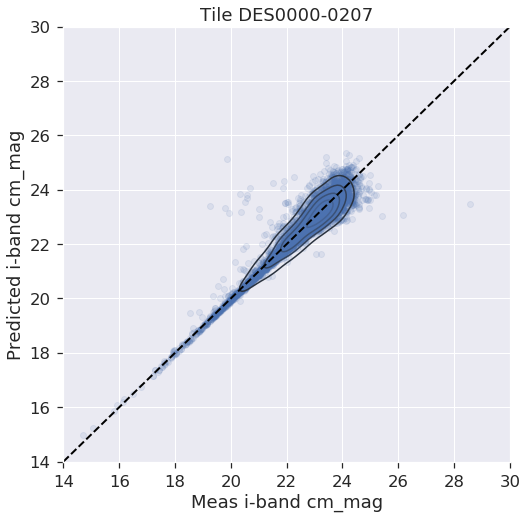

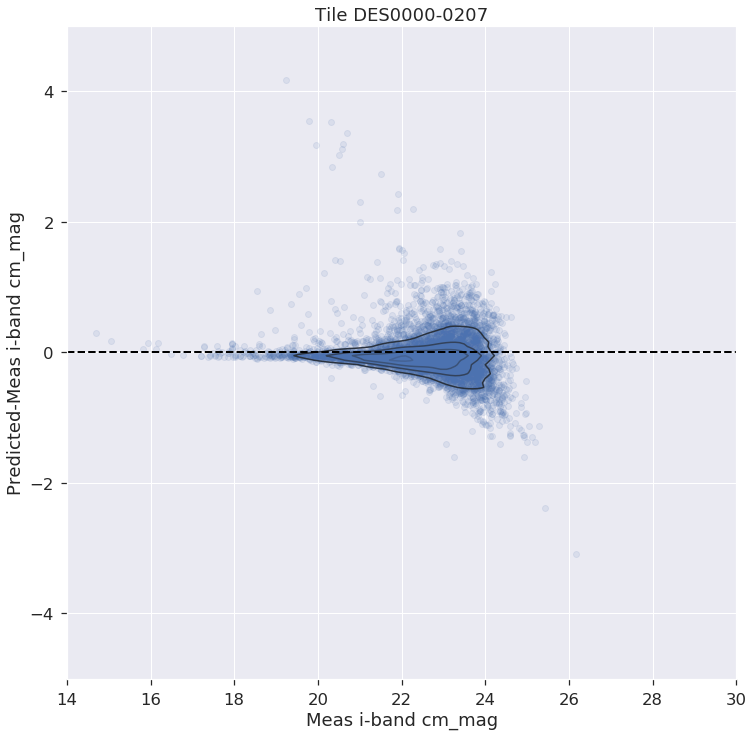

Text(0.5, 1.0, 'Tile DES0000-0207')

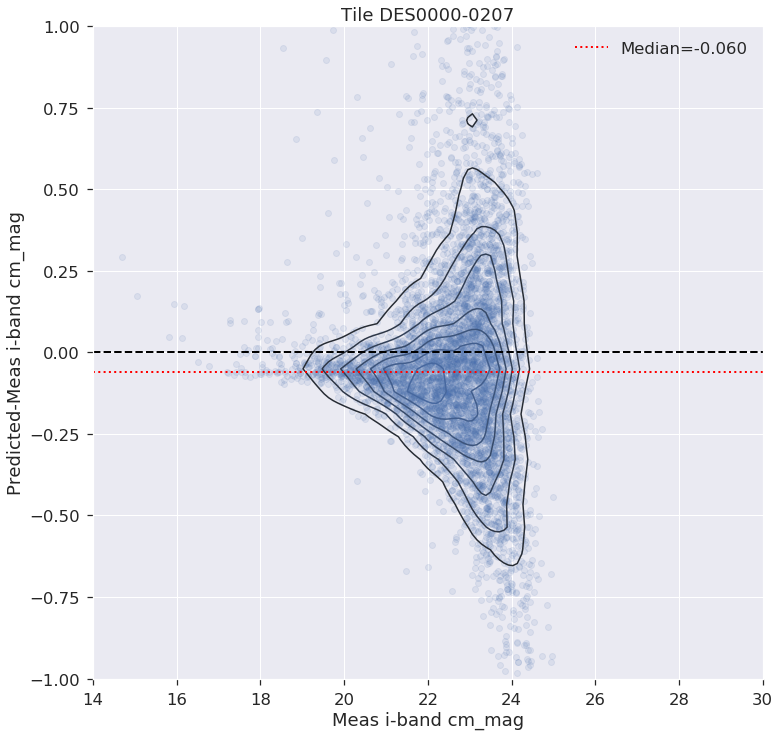

In [32]:
bi = 2
b = 'griz'[bi]
N = 5
n_levels = 4

x = bal['meas_cm_mag'][:,bi]
y = bal[f'predicted_sof_cm_mag_{b}']
plt.scatter(x, y, alpha=0.1)
plt.plot([14, 30], [14, 30], ls='--', lw=2, c='k')
sb.kdeplot(x[::N], y[::N], n_levels=n_levels)
plt.xlim([14, 30])
plt.ylim([14, 30])
plt.xlabel(f'Meas {b}-band cm_mag')
plt.ylabel(f'Predicted {b}-band cm_mag')
plt.gcf().set_size_inches(8, 8)
plt.title(f'Tile {tile}')
plt.show()

x = bal['meas_cm_mag'][:,bi]
y = bal[f'predicted_sof_cm_mag_{b}'] - x
plt.scatter(x, y, alpha=0.1)
plt.axhline(0, ls='--', lw=2, c='k')
sb.kdeplot(x[::N], y[::N], n_levels=n_levels)
plt.xlim([14, 30])
plt.ylim([-5, 5])
plt.xlabel(f'Meas {b}-band cm_mag')
plt.ylabel(f'Predicted-Meas {b}-band cm_mag')
plt.gcf().set_size_inches(12, 12)
plt.title(f'Tile {tile}')
plt.show()

x = bal['meas_cm_mag'][:,bi]
y = bal[f'predicted_sof_cm_mag_{b}'] - x
plt.scatter(x, y, alpha=0.1)
plt.axhline(0, ls='--', lw=2, c='k')
med = np.median(y)
plt.axhline(med, ls=':', lw=2, c='r', label=f'Median={med:.3f}')
plt.legend()
sb.kdeplot(x[::N], y[::N], n_levels=n_levels*2)
plt.xlim([14, 30])
plt.ylim([-1, 1])
plt.xlabel(f'Meas {b}-band cm_mag')
plt.ylabel(f'Predicted-Meas {b}-band cm_mag')
plt.gcf().set_size_inches(12, 12)
plt.title(f'Tile {tile}')

Text(0.5, 1.0, 'Tile DES0000-0207')

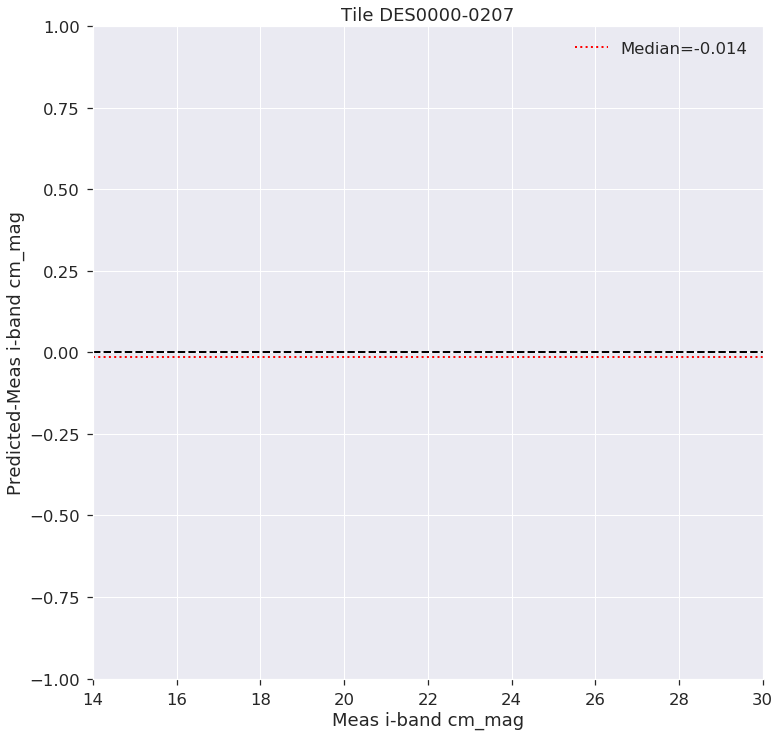

In [34]:
x = bal['meas_cm_mag'][:,bi]- bal['meas_cm_mag'][:,bi+1]
b2 = 'griz'[bi+1]
y = bal[f'predicted_sof_cm_mag_{b}']-bal[f'predicted_sof_cm_mag_{b2}'] - x
plt.scatter(x, y, alpha=0.1)
plt.axhline(0, ls='--', lw=2, c='k')
med = np.median(y)
plt.axhline(med, ls=':', lw=2, c='r', label=f'Median={med:.3f}')
plt.legend()
sb.kdeplot(x[::N], y[::N], n_levels=n_levels*2)
plt.xlim([14, 30])
plt.ylim([-1, 1])
plt.xlabel(f'Meas {b}-band cm_mag')
plt.ylabel(f'Predicted-Meas {b}-band cm_mag')
plt.gcf().set_size_inches(12, 12)
plt.title(f'Tile {tile}')